In [9]:
!pip install keras

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report,roc_auc_score

In [53]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/CICDataset/cicddos2019_dataset.csv', index_col=False)

drop_columns = [
    "Flow ID",
    'Fwd Header Length.1',
    "Source IP", "Src IP",
    "Source Port", "Src Port",
    "Destination IP", "Dst IP",
    "Destination Port", "Dst Port",
    "Timestamp",
    "Unnamed: 0", "Inbound", "SimillarHTTP", 'Label'
]

data = data.drop(columns=drop_columns, errors='ignore')


le = LabelEncoder()

data['Labels'] = le.fit_transform(data['Class'])  # 'Benign' becomes 1, 'DDoS' becomes 0
if le.classes_[0] == 'Attack':
    data['Labels'] = 1 - data['Labels']


labels = data["Labels"]


# Drop the 'Class' column after encoding
data = data.drop(columns=['Class'], errors='ignore')

# Handle missing values by replacing them with zeros
data.fillna(0, inplace=True)

# Drop duplicate rows from the dataset
data.drop_duplicates(inplace=True)

selector = VarianceThreshold(threshold=0.9)
data_var = selector.fit_transform(data)
data = pd.DataFrame(data_var, columns=data.columns[selector.get_support(indices=True)])

# Drop columns with more than 80% zeros
zero_threshold = 0.8  # Set the threshold for dropping columns
non_zero_counts = (data != 0).sum(axis=0)  # Count non-zero values per column
non_zero_fraction = non_zero_counts / len(data)  # Calculate the fraction of non-zero values

# Keep columns where the fraction of non-zero values is greater than (1 - zero_threshold)
columns_to_keep = non_zero_fraction[non_zero_fraction > (1 - zero_threshold)].index
data = data[columns_to_keep]
data['Labels'] = labels


print(data.head(10))
# print(data.var())


   Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0      17.0       216631.0                6.0                     0.0   
1      17.0            2.0                2.0                     0.0   
2      17.0           48.0                2.0                     0.0   
3      17.0       107319.0                4.0                     0.0   
4      17.0       107271.0                4.0                     0.0   
5      17.0           48.0                2.0                     0.0   
6      17.0            1.0                2.0                     0.0   
7      17.0       109142.0                4.0                     0.0   
8      17.0            1.0                2.0                     0.0   
9      17.0       215834.0                6.0                     0.0   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                    2088.0                       0.0                  393.0   
1                     802.0         

<ipython-input-53-07ff10b93ff0>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Labels'] = labels


In [54]:
# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

labels = data["Labels"]

# Split the data into normal (BENIGN) and DDoS attack data
X_normal = data_scaled[labels == 0]
X_ddos = data_scaled[labels == 1]

# Train-test split (Train the model only on normal traffic data)
X_train, X_test = train_test_split(X_normal, test_size=0.2, random_state=42)

print("Normal Data Shape:", X_normal.shape)
print("DDoS Data Shape:", X_ddos.shape)

Normal Data Shape: (85216, 48)
DDoS Data Shape: (333540, 48)


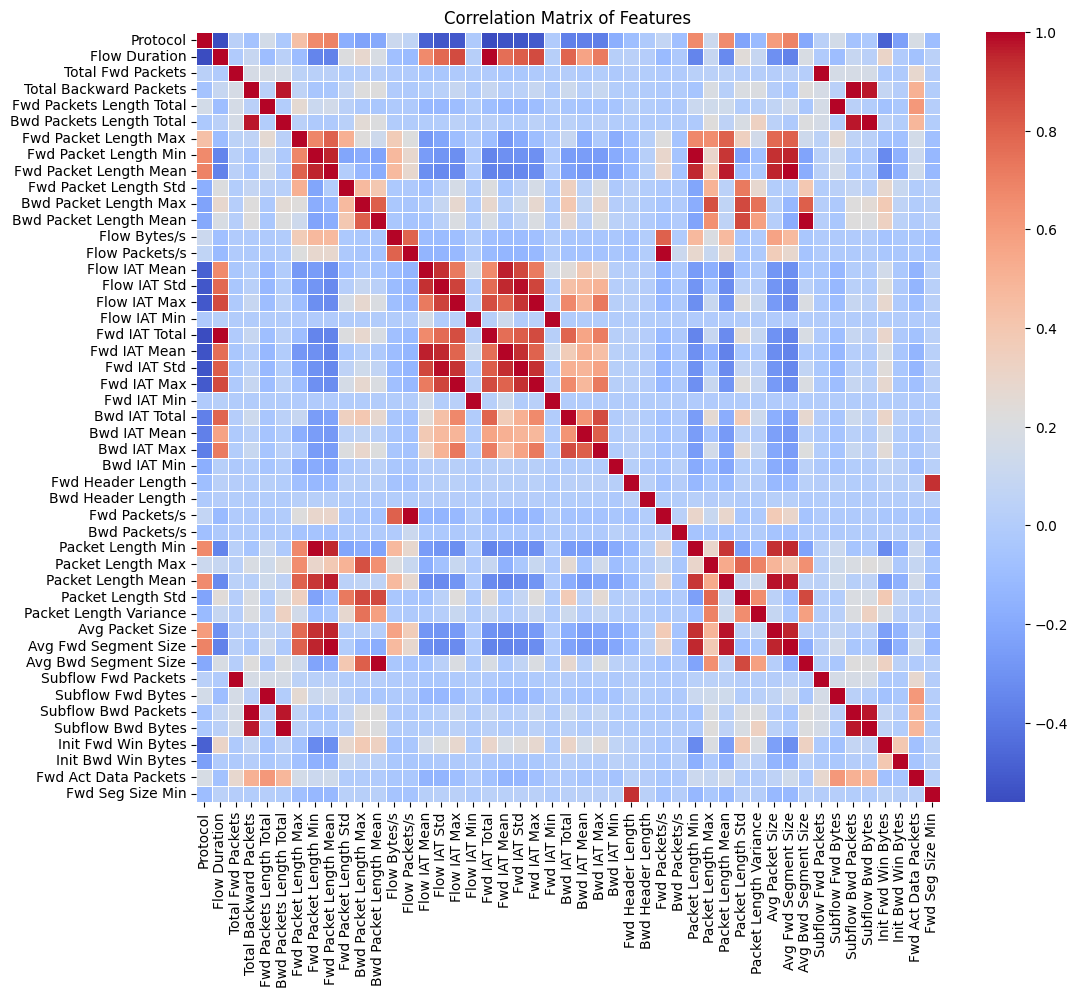

In [55]:
# Compute the correlation matrix
correlation_matrix = data.drop(columns=['Labels']).corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

In [56]:
'''
input_dim: This determines the number of features in the input data (X_train). The autoencoder will take data with this number of features as input.
encoding_dim: This is the size of the first encoded layer, which will compress the input data into a lower-dimensional representation.

'''
input_dim = X_train.shape[1]
encoding_dim = 16


'''
autoencoder.add(Dense(encoding_dim, activation="relu", input_shape=(input_dim,))):
    This is the first layer, which maps the input to the compressed layer.
    It has encoding_dim neurons (16 in this case) and uses the ReLU activation function to introduce non-linearity.

autoencoder.add(Dense(int(encoding_dim / 2), activation="relu")):
    This layer further reduces the dimensionality. It has int(encoding_dim / 2)

autoencoder.add(Dense(int(encoding_dim / 4), activation="relu")):
    This is the smallest layer, with int(encoding_dim / 4) neurons (4 neurons here).
    It represents the "bottleneck" where the input is compressed into a much smaller latent space.

Output Layer:
autoencoder.add(Dense(input_dim, activation="sigmoid")):
    This layer reconstructs the output to match the original input dimensionality (input_dim).
    The sigmoid activation function is used to constrain the output values between 0 and 1,
    which is common when working with normalized data.
'''
autoencoder = Sequential()
autoencoder.add(Dense(encoding_dim, activation="relu", input_shape=(input_dim,)))
autoencoder.add(Dense(int(encoding_dim / 2), activation="relu"))
autoencoder.add(Dense(int(encoding_dim / 4), activation="relu"))
autoencoder.add(Dense(int(encoding_dim / 2), activation="relu"))
autoencoder.add(Dense(encoding_dim, activation="relu"))
autoencoder.add(Dense(input_dim, activation="sigmoid"))

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2, shuffle=True)



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1705/1705 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0490 - val_loss: 0.0025
Epoch 2/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 3/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 4/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0010 - val_loss: 9.9755e-04
Epoch 6/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.5184e-04 - val_loss: 9.1057e-04
Epoch 7/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.6334e-04 - val_loss: 8.6475e-04
Epoch 8/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 8.0449e-04 - val_loss: 7.8878e-04
Epoch 9/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 7.3531e-04 - val_loss: 7.5443e-04
Epoch 10/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.9323e-04 - val_loss: 6.9544e-04


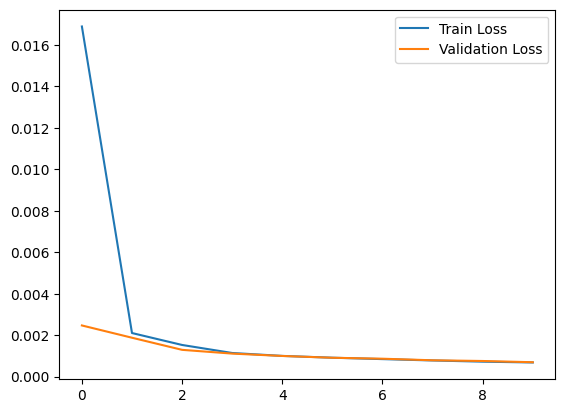

In [57]:
# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [58]:
# Use the autoencoder to reconstruct the test data
X_test_pred = autoencoder.predict(X_test)
X_test_mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Set a threshold for classification (based on reconstruction error on normal data)
threshold = np.percentile(X_test_mse, 95)
print(f"Reconstruction error threshold: {threshold}")

# Test the model on both normal and DDoS data
X_ddos_pred = autoencoder.predict(X_ddos)
X_ddos_mse = np.mean(np.power(X_ddos - X_ddos_pred, 2), axis=1)

# Classify based on the reconstruction error
y_test_pred = X_test_mse > threshold
y_ddos_pred = X_ddos_mse > threshold

# Print results
print(f"Normal Traffic Detection Accuracy: {100 - np.mean(y_test_pred) * 100:.2f}%")
print(f"DDoS Attack Detection Accuracy: {np.mean(y_ddos_pred) * 100:.2f}%")

y_true = np.concatenate([np.zeros(len(X_test)), np.ones(len(X_ddos))])
y_pred = np.concatenate([y_test_pred, y_ddos_pred])

print(classification_report(y_true, y_pred, target_names=["BENIGN", "DDoS"]))

# Calculate and print the ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred)
print(f"ROC-AUC Score: {roc_auc:.4f}")

533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Reconstruction error threshold: 0.002626639424968027
10424/10424 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Normal Traffic Detection Accuracy: 95.00%
DDoS Attack Detection Accuracy: 100.00%
              precision    recall  f1-score   support

      BENIGN       1.00      0.95      0.97     17044
        DDoS       1.00      1.00      1.00    333540

    accuracy                           1.00    350584
   macro avg       1.00      0.97      0.99    350584
weighted avg       1.00      1.00      1.00    350584

ROC-AUC Score: 0.9750


An ROC-AUC score of 0.9750 means that the model can correctly distinguish between normal (Benign) and attack (DDoS) traffic 97.5% of the time, which reflects strong performance.